## Load dataset

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


dataset = pd.read_csv('../Normalization/A1-synthetic-normalized.csv', sep='\t')
print(dataset.head())

# basic statistics
print(dataset.describe())

# check for missing values
print(dataset.isnull().sum())

input_columns = ['#v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']
output_column = 'z'

        #v1        v2        v3        v4        v5        v6        v7  \
0  1.280663 -0.793451  1.616521  1.004039 -0.676741  2.553385 -0.466353   
1  0.109896  1.522669 -0.154310 -0.992534  0.008298  1.684637 -0.344116   
2 -1.172442 -0.062932 -0.964088 -0.877683  0.109029  1.335112  0.121703   
3 -1.640673  0.863717  1.460254  0.860615  1.196895  0.572846  0.973119   
4 -1.496693 -1.521392 -0.693229 -1.218331 -0.559655  0.323990 -0.190274   

         v8        v9         z  
0 -0.674985  1.886479  1.416377  
1 -0.674985 -0.358487 -0.323709  
2  1.481516 -0.967034 -0.820304  
3 -0.674985  1.869298  1.715855  
4 -0.674985 -0.849809 -1.158785  
                #v1            v2            v3            v4            v5  \
count  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03  1.000000e+03   
mean   1.243450e-17  3.318235e-15 -7.638334e-17  1.705303e-16  1.438849e-16   
std    1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00  1.000500e+00   
min   -1.792411e+00 -1.721945

## MyNeuralNetwork class

In [48]:
class MyNeuralNetwork:
    def __init__(self, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage):
        self.L = num_layers
        self.n = num_units
        self.num_epochs = num_epochs
        self.eta = learning_rate
        self.alpha = momentum
        self.fact = activation_function
        self.validation_percentage = validation_percentage
        self.xi = [np.zeros(layer_units) for layer_units in num_units]
        self.h = [np.zeros(layer_units) for layer_units in num_units]
        self.w = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.theta = [np.zeros(layer_units) for layer_units in num_units]
        self.delta = [np.zeros(layer_units) for layer_units in num_units]
        self.d_w = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.d_theta = [np.zeros(layer_units) for layer_units in num_units]
        self.d_w_prev = [None] + [np.zeros((num_units[i], num_units[i - 1])) for i in range(1, num_layers)]
        self.d_theta_prev = [np.zeros(layer_units) for layer_units in num_units]
        self.training_error = []
        self.validation_error = []

    # Sigmoid activation function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def linear(self, x):
        return x

    def linear_derivative(self, x):
        return np.ones_like(x)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - x**2

    def activation(self, x):
        if self.fact == 'sigmoid':
            return self.sigmoid(x)
        elif self.fact == 'relu':
            return self.relu(x)
        elif self.fact == 'linear':
            return self.linear(x)
        elif self.fact == 'tanh':
            return self.tanh(x)

    def activation_derivative(self, x):
        if self.fact == 'sigmoid':
            return self.sigmoid_derivative(x)
        elif self.fact == 'relu':
            return self.relu_derivative(x)
        elif self.fact == 'linear':
            return self.linear_derivative(x)
        elif self.fact == 'tanh':
            return self.tanh_derivative(x)

    def feed_forward(self, sample):
        self.xi[0] = sample
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l - 1]) - self.theta[l]
            self.xi[l] = self.activation(self.h[l])

    def backpropagate(self, target):
        self.delta[self.L - 1] = self.activation_derivative(self.xi[self.L - 1]) * (self.xi[self.L - 1] - target)
        for l in range(self.L - 2, 0, -1):
            self.delta[l] = self.activation_derivative(self.xi[l]) * np.dot(self.w[l + 1].T, self.delta[l + 1])

    def update_weights(self):
        for l in range(1, self.L):
            self.d_w[l] = -self.eta * np.outer(self.delta[l], self.xi[l - 1]) + self.alpha * self.d_w_prev[l]
            self.d_theta[l] = self.eta * self.delta[l] + self.alpha * self.d_theta_prev[l]
            self.w[l] += self.d_w[l]
            self.theta[l] += self.d_theta[l]
            self.d_w_prev[l] = self.d_w[l]
            self.d_theta_prev[l] = self.d_theta[l]

    def calculate_total_error(self, X, y):
        total_error = 0.0
        for i in range(X.shape[0]):
            self.feed_forward(X[i])
            total_error += 0.5 * np.sum((self.xi[self.L - 1] - y[i]) ** 2)
        return total_error

    def fit(self, X, y):
        # splitting data into training and validation sets
        n_samples = X.shape[0]
        if self.validation_percentage > 0:
            n_train = int(n_samples * (1.0 - self.validation_percentage))
            X_train = X[:n_train]
            y_train = y[:n_train]
            X_val = X[n_train:]
            y_val = y[n_train:]
        else:
            X_train = X
            y_train = y
            X_val = np.array([])
            y_val = np.array([])

        for epoch in range(self.num_epochs):
            for i in range(X_train.shape[0]):
                sample = X_train[i]
                target = y_train[i]

                self.feed_forward(sample)
                self.backpropagate(target)
                self.update_weights()

            # calculate training error
            train_error = self.calculate_total_error(X_train, y_train)
            self.training_error.append(train_error)

            # calculate validation error
            if X_val.shape[0] > 0:
                val_error = self.calculate_total_error(X_val, y_val)
                self.validation_error.append(val_error)

    def predict(self, X):
        predictions = []
        for sample in X:
            self.feed_forward(sample)
            predictions.append(self.xi[self.L - 1].copy())
        return np.array(predictions)

    # function to retrieve epoch-wise loss data
    def get_epoch_losses(self):
        epochs = list(range(1, self.num_epochs + 1))
        return np.column_stack((epochs, self.training_error, self.validation_error))

    # modify the loss_epochs() function to use get_epoch_losses()
    def loss_epochs(self):
        return self.get_epoch_losses()


## Utility functions

In [49]:
# function to train neural network on a given dataset
def train_neural_network(dataset, input_columns, output_column, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage):
    X = dataset[input_columns].values
    y = dataset[output_column].values.reshape(-1, 1)

    nn = MyNeuralNetwork(num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage)
    
    nn.fit(X, y)
    
    X_test = X  
    predictions = nn.predict(X_test)

    return nn, predictions

# function to calculate Mean Absolute Percentage Error (MAPE)
def calculate_mape(y_true, y_pred):
    epsilon = 1e-10  # a small value to avoid division by zero
    mask = y_true != 0  # creating a mask to handle zero values in y_true
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    return 100 * np.mean(np.abs((y_true_masked - y_pred_masked) / (y_true_masked + epsilon)))

## Neural network configuration

In [50]:
num_layers = 4
num_units = [len(input_columns)] + [10, 5, 1]
num_epochs = 100
learning_rate = 0.1
momentum = 0.9
activation_function = "sigmoid"
validation_percentage = 0.2

nn, predictions = train_neural_network(dataset, input_columns, output_column, num_layers, num_units, num_epochs, learning_rate, momentum, activation_function, validation_percentage)


## Scatter plot

MAPE for Dataset: 96.52%


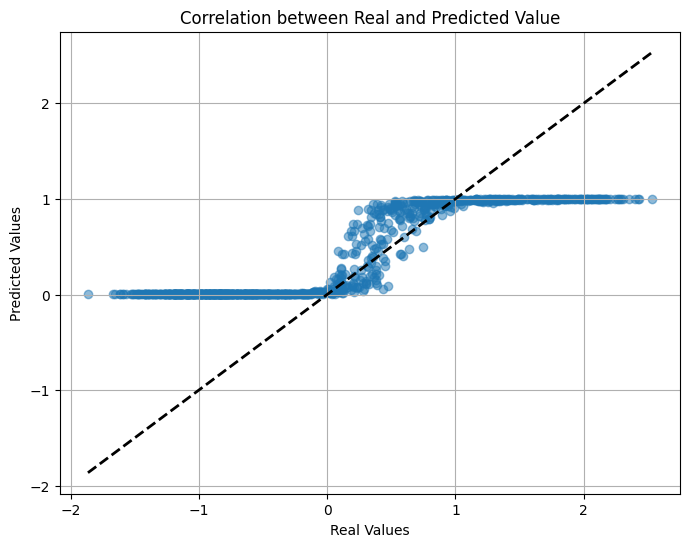

In [51]:
real_values = dataset[output_column].values.reshape(-1, 1)
mape = calculate_mape(real_values, predictions)
print(f"MAPE for Dataset: {mape:.2f}%")


plt.figure(figsize=(8, 6))
plt.scatter(real_values, predictions, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Correlation between Real and Predicted Value')
plt.grid(True)
plt.plot([real_values.min(), real_values.max()], [real_values.min(), real_values.max()], 'k--', lw=2) # diagonal line
plt.show()

## Training and validation error evolution

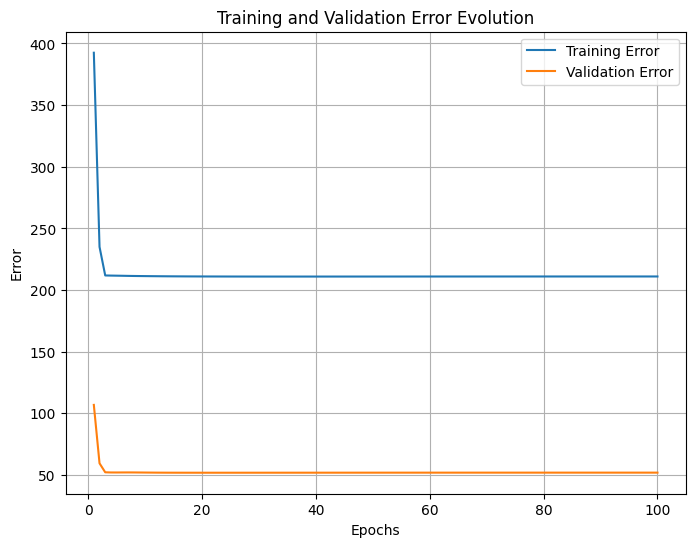

In [52]:
loss_data = nn.loss_epochs()


plt.figure(figsize=(8, 6))
plt.plot(loss_data[:, 0], loss_data[:, 1], label='Training Error')
plt.plot(loss_data[:, 0], loss_data[:, 2], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error Evolution')
plt.legend()
plt.grid(True)
plt.show()